In [1]:
!pip install open3d

## Make sure that the DEVICE that's printed out is 'cuda'. This means that Pytorch is able to use your GPU.

In [2]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib import ticker

np.random.seed(0)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
torch.cuda.empty_cache()

cuda


## Definition of Gaussian Process Class. Read the comments below for more information about Pytorch.

In [12]:
### -------------------------------- ###
# Question 2a
class GaussianProcess():
    def __init__(self, X1, Y1, kernel_func=None, noise=1e-2):
        # X1: (N x 3) inputs of training data
        # Y1: (N x 1) outputs of training data
        # kernel_func: (function) a function defining your kernel. It should take the form f(X1, X2) = K, where K is N x N if X1, X2 are N x k.
        # where k is the number of feature dimensions

        self.noise = noise
        self.X1 = X1
        self.Y1 = Y1

        self.kernel_func = kernel_func

        self.compute_training_covariance()

        self.noise_term = self.noise * torch.eye(self.X1.shape[0], device=DEVICE)

    def compute_training_covariance(self):
        # Computes the training covariance matrix Σ11(X, X) using self.kernel_func and your input data self.X1

        ### STUDENT CODE BEGINS ###
        self.Σ11 = self.kernel_func(self.X1, self.X1) # (N X N)
        N = self.X1.shape[0]
        self.Σ11 += self.noise * torch.eye(self.X1.shape[0], device=DEVICE)
        ### STUDENT CODE ENDS ###

    def compute_posterior(self, X):
        # X: (N x k) set of inputs used to predict
        # μ2: (N x 1) GP means at inputs X
        # Σ2: (N x N) GP means at inputs X

        # sizes
        N = self.X1.shape[0] # num of prior data points, 3-dimension
        M = X.shape[0] # num of new data points, k-dimesion

        # cov Σy_ (based on prior data)
        Σy_ = self.Σ11

        # cross cov, Σyy1:N
        Σyy_ = self.kernel_func(X, self.X1)

        # cov Σy (based on new data)
        Σy = self.kernel_func(X, X)

        # Compute posterior mean
        μ2 = Σyy_ @ torch.linalg.inv(Σy_) @ self.Y1 # (MxN)(NxN)
        # Compute the posterior covariance
        Σ2 = Σy - Σyy_ @ torch.linalg.inv(Σy_) @ Σyy_.T # (MxM) + (MxN)(NXN)(NxM)

        return μ2, Σ2  # posterior mean, covariance

###### KERNELS ######

# Question 2c
def radial_basis(X1, X2, sig=1.2, l=0.1):
    # Implement the radial basis kernel, given two data matrices X1 and X2
    # X1: Input data (N x k)
    # X2: Input data (M x k)
    # returns K (N x M) matrix

    ### STUDENT CODE BEGINS ###
    # N, k = X1.shape
    # M, k = X2.shape

    # Suggestions for those unfamiliar with Python / Numpy / Pytorch.
    # Step 1: For every row in X1 and every row in X2 (N x M combinations in total),
    # you want to compute some sort of distance. You can easily do this through array broadcasting.
    # If you convert X1 into a tensor (N x 1 x k) and X2 into a tensor (1 x M x k), their difference
    # will be a (N x M x k) tensor, where the (i,j) element is a k-dimensional vector that represents the
    # difference between the i-th row of X1 and the j-th row of X2. You can use the built-in methods of the tensors:
    # X.reshape(dim0, dim1, dim2).

    # You may find the following functions useful:
    # torch.linalg.norm( ... , dim=-1) -> This takes the norm in the last dimension of a tensor.
    # torch.exp( ... ) -> This is the same as the np equivalent. Takes the element-wise exponent.

    # Reshape X1 and X2 for broadcasting
    X1_reshaped = X1[:, None, :] # (N x 1 x k)
    X2_reshaped = X2[None, :, :] # (1 x M x k)
    # print("X1:", X1_reshaped.shape, "X2:", X2_reshaped.shape)

    # Compute the difference between X1 and X2 for each pair of points
    diff = X1_reshaped - X2_reshaped # (N x M x k)
    squared_norm = torch.linalg.norm((diff), axis=-1)**2 # compute it over the last axis (N x M)

    # Compute the Radial Basis Function kernel using the formula
    rbf_kernel = (sig**2) * torch.exp(-squared_norm / (2 * l**2))

    return rbf_kernel


## Read and downsample the point clouds. The relevant files you can put in the Files tab (below Secrets).

In [13]:
# Load terrain
terrain = o3d.io.read_point_cloud('terrain.ply')
terrain_noisy = o3d.io.read_point_cloud('terrain_noisy.ply')

# Downsample
terrain_down = terrain.uniform_down_sample(100)
terrain_noisy_down = terrain_noisy.uniform_down_sample(100)
print(terrain_down.points)

std::vector<Eigen::Vector3d> with 14307 elements.
Use numpy.asarray() to access data.


## Convert the point clouds into tensors for Pytorch, and create the dataset.

In [14]:
terrain_down_np = np.asarray(terrain_down.points)
terrain_noisy_down_np = np.asarray(terrain_noisy_down.points)

terrain_down_tensor = torch.tensor(terrain_down_np, device=DEVICE)
terrain_noisy_down_tensor = torch.tensor(terrain_noisy_down_np, device=DEVICE)

X_test = terrain_down_tensor[:,0:2]
Y_test = terrain_down_tensor[:,2]

X_train = terrain_noisy_down_tensor[:,0:2]
Y_train = terrain_noisy_down_tensor[:,2]
# print(terrain_noisy_down_np[0:10,:])
# print(terrain_noisy_down_np[0:10,0:2])
# print(terrain_noisy_down_np[0:10,2])


## Instantiate the Gaussian Process Class

In [15]:
gp = GaussianProcess(X_train, Y_train, kernel_func=radial_basis)

## Compute the Posterior on the Training Data

In [16]:
mu_train, Sigma_train = gp.compute_posterior(X_train)

mu_train = mu_train.cpu().numpy()
Sigma_train = Sigma_train.cpu().numpy()
Y_train = Y_train.cpu().numpy()


## Compute Mean Squared Error on Training

In [8]:
### STUDENT CODE BEGINS ###
diff = mu_train - Y_train
N = mu_train.shape[0]
# print(mu_train[0:20],Y_train[0:20])
square_norm = np.linalg.norm(diff) ** 2
mse_train = square_norm/N
print(square_norm, N, mse_train)
### STUDENT CODE ENDS

35.07663523116266 14012 0.0025033282351671895


## Compute the Posterior on the Test Data

In [9]:
mu_test, Sigma_test = gp.compute_posterior(X_test)
mu_test = mu_test.cpu().numpy()
Sigma_test = Sigma_test.cpu().numpy()


## Compute Mean Squared Error on Test

In [10]:
### STUDENT CODE BEGINS ###
Y_test = Y_test.cpu().numpy()
diff = mu_test - Y_test
N = mu_test.shape[0]
# print(mu_train[0:20],Y_train[0:20])
square_norm = np.linalg.norm(diff) ** 2
mse_test = square_norm/N
print(square_norm, N, mse_test)### STUDENT CODE ENDS ###

121.88413213647354 14307 0.008519195648037572


## Plotting

Text(0.5, 0, 'x')

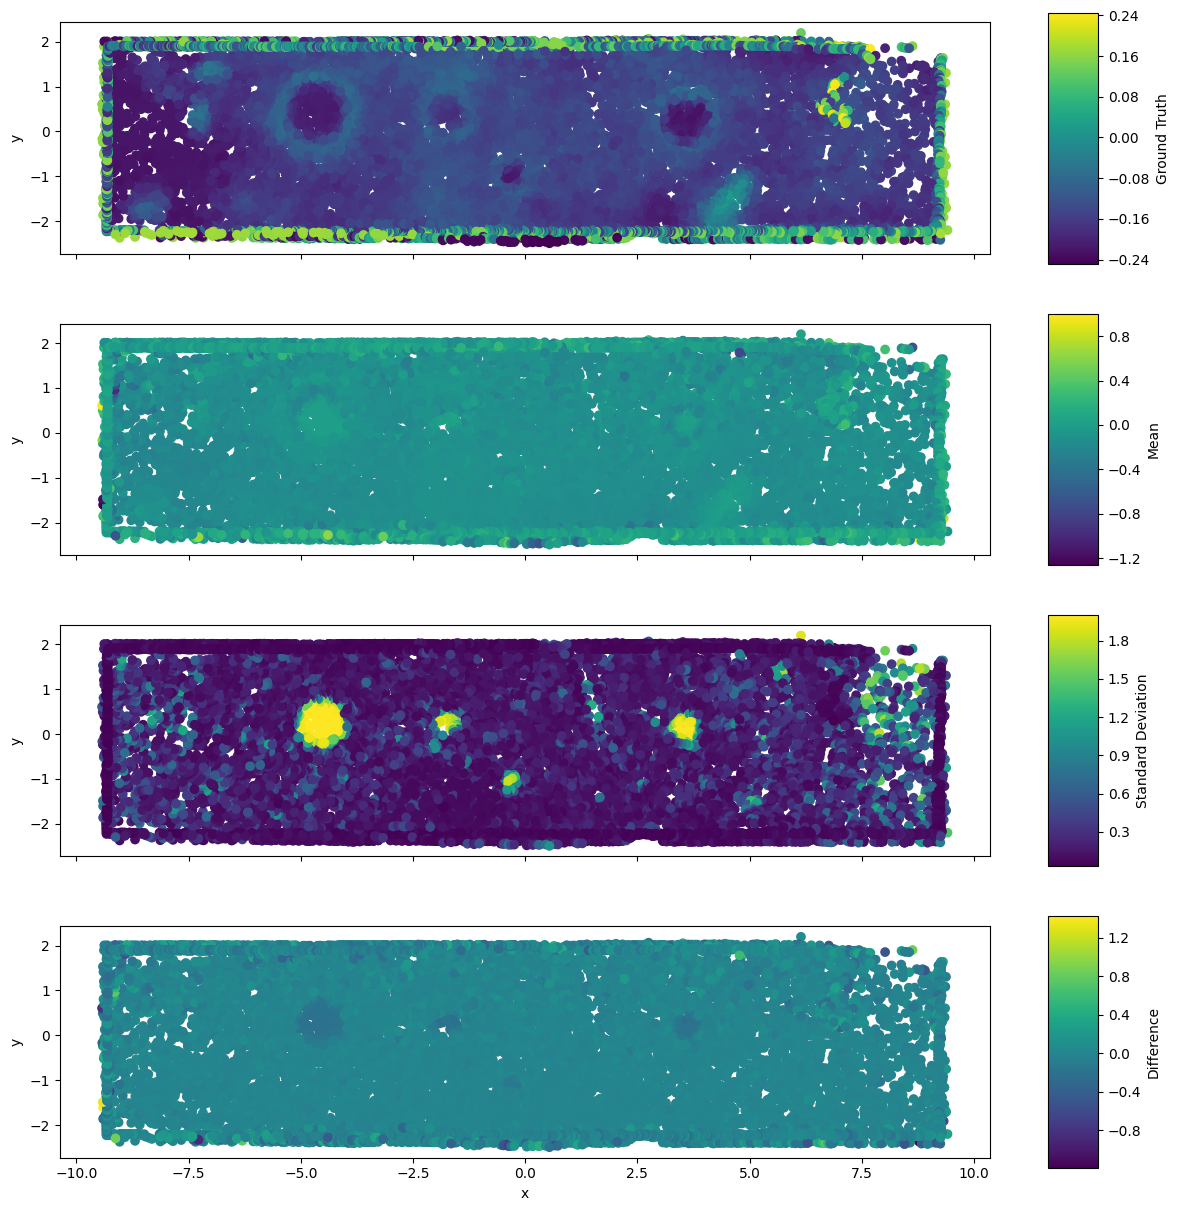

In [11]:
### STUDENT CODE BEGINS ###
# Y_test = Y_test.cpu().numpy()
X_test = X_test.cpu().numpy()

mean = mu_test
std = np.sqrt(np.diag(Sigma_test))
error = Y_test - mu_test

### STUDENT CODE ENDS ###


# Use the built-in colormaps and normalization
# Also include the colorbars
fig, ax = plt.subplots(4, figsize=(15, 15), sharex=True)

# Plot the values with a colorbar
vals_to_plot = [Y_test, mean, std, error]
names_to_plot = ['Ground Truth', 'Mean', 'Standard Deviation', 'Difference']

for i, (vals, name) in enumerate(zip(vals_to_plot, names_to_plot)):
    im = ax[i].scatter(X_test[:, 0], X_test[:, 1], c=vals, cmap='viridis')
    ax[i].set_aspect('equal', adjustable='box')

    # Add a y-label (x is shared)
    ax[i].set_ylabel('y')

    # Add a colorbar
    cb = plt.colorbar(im, ax=ax[i], aspect=5)

    # Add more ticks to the colorbar
    tick_locator = ticker.MaxNLocator(nbins=7)
    cb.locator = tick_locator
    cb.update_ticks()

    # Label the colorbar
    cb.set_label(name)

# Add an x-label
ax[-1].set_xlabel('x')